In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles

import tqdm

import torch

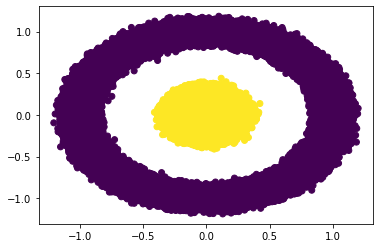

In [2]:
X, y = make_circles(n_samples=1000000, noise=0.05, random_state=1, factor = 0.2)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

The size of the dataset is so large to train at a time. We need to split the data into batches. We'll do this using pytorch dataloader.

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx, :]
        y = self.y[idx]
        return X, y

In [4]:
train_dataset = CustomDataset(X, y)
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [5]:
class NonLinearClassifier(torch.nn.Module):
    def __init__(self, input_size):
        super(NonLinearClassifier, self).__init__()
        self.layer_1 = torch.nn.Linear(input_size, 100)
        self.layer_2 = torch.nn.Linear(100, 1)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(p=0.2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        return self.sigmoid(x)

In [6]:
non_linear_model = NonLinearClassifier(input_size=2).to("cuda")
loss_fn = torch.nn.BCELoss().to("cuda")
optimizer = torch.optim.SGD(non_linear_model.parameters(), lr=0.01)

In [7]:
prev_loss = 0
for epoch in range(2):
    non_linear_model.train() # Set the model to training mode

    with tqdm.tqdm(training_loader) as bar:
        for batch_x, batch_y in bar:
            batch_x = batch_x.to("cuda")
            batch_y = batch_y.to("cuda")
            y_pred = non_linear_model(batch_x.float()) # Evaluate the model on the training data
            loss = loss_fn(y_pred.float(), batch_y.float()) # Calculate the loss

            # Early stopping
            # if (abs(loss.item() - prev_loss)) < 1e-6:
            #     print(f"Converged after {epoch} epochs")
            #     break
            # print("Model params: ", model.state_dict())
            optimizer.zero_grad() # Reset the gradients for optimizer
            loss.backward() # Calculate the gradients for loss_fn wrt model parameters
            optimizer.step() # Update the model parameters

            # non_linear_model.eval() # Set the model to evaluation mode
            # y_pred_test = non_linear_model(X_test) # Evaluate the model on the test data
            # loss_test = loss_fn(y_pred_test, y_test) # Calculate the loss

    prev_loss = loss.item()
    # print(f"Epoch: {epoch}, loss: {loss.item()}, loss_test: {loss_test.item()}")
    print(f"Epoch: {epoch}, loss: {loss.item()}")

        

100%|██████████| 7813/7813 [00:15<00:00, 514.79it/s]


Epoch: 0, loss: 0.028785018250346184


100%|██████████| 7813/7813 [00:17<00:00, 456.83it/s]

Epoch: 1, loss: 0.014803113415837288


In [8]:
non_linear_model.eval() # Set the model to evaluation mode

NonLinearClassifier(
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)

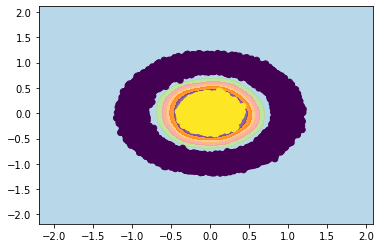

In [9]:
# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
grid = torch.cat((torch.Tensor(xx.reshape(-1, 1)), torch.Tensor(yy.reshape(-1, 1))), 1)
grid = grid.type(torch.FloatTensor)
pred_grid = non_linear_model(grid.to("cuda")).to("cuda")
pred_grid = pred_grid.reshape(xx.shape)
plt.contourf(xx, yy, pred_grid.cpu().detach().numpy(), cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()